In [27]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=ad07efe531c940485f9acdc3188f26c6b4d03660221ebb575faf193acfde9c1b
  Stored in directory: /root/.cache/pip/wheels/2b/4d/8f/55fb4f7b9b591891e8d3f72977c4ec6c7763b39c19f0861595
Successfully built GPUtil


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

Trainable parameters: 787970

Epoch 1/10


100%|██████████| 88/88 [00:17<00:00,  4.90it/s]


Train Loss: 0.9637 | Train Acc: 0.5807 | Time: 72.11s
Val Loss: 0.6897 | Val Acc: 0.6214
Precision: 0.6381 | Recall: 0.5384 | F1: 0.5840 | ROC-AUC: 0.6719
CM:
[[498 211]
 [319 372]]

Epoch 2/10


100%|██████████| 88/88 [00:18<00:00,  4.71it/s]


Train Loss: 0.6951 | Train Acc: 0.6025 | Time: 74.89s
Val Loss: 0.6820 | Val Acc: 0.6050
Precision: 0.5871 | Recall: 0.6729 | F1: 0.6271 | ROC-AUC: 0.6526
CM:
[[382 327]
 [226 465]]

Epoch 3/10


100%|██████████| 88/88 [00:18<00:00,  4.70it/s]


Train Loss: 0.6618 | Train Acc: 0.6362 | Time: 75.20s
Val Loss: 0.6487 | Val Acc: 0.6479
Precision: 0.6431 | Recall: 0.6440 | F1: 0.6435 | ROC-AUC: 0.6973
CM:
[[462 247]
 [246 445]]

Epoch 4/10


100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.6579 | Train Acc: 0.6398 | Time: 75.22s
Val Loss: 0.6532 | Val Acc: 0.6193
Precision: 0.6042 | Recall: 0.6628 | F1: 0.6322 | ROC-AUC: 0.6805
CM:
[[409 300]
 [233 458]]

Epoch 5/10


100%|██████████| 88/88 [00:18<00:00,  4.68it/s]


Train Loss: 0.6545 | Train Acc: 0.6429 | Time: 75.14s
Val Loss: 0.6516 | Val Acc: 0.6457
Precision: 0.6387 | Recall: 0.6498 | F1: 0.6442 | ROC-AUC: 0.6847
CM:
[[455 254]
 [242 449]]

Epoch 6/10
Unfreezing ViT...


100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.6494 | Train Acc: 0.6393 | Time: 115.38s
Val Loss: 0.6499 | Val Acc: 0.6393
Precision: 0.6462 | Recall: 0.5948 | F1: 0.6194 | ROC-AUC: 0.6925
CM:
[[484 225]
 [280 411]]

Epoch 7/10


100%|██████████| 88/88 [00:18<00:00,  4.68it/s]


Train Loss: 0.6550 | Train Acc: 0.6471 | Time: 115.22s
Val Loss: 0.6471 | Val Acc: 0.6571
Precision: 0.6401 | Recall: 0.6975 | F1: 0.6676 | ROC-AUC: 0.7019
CM:
[[438 271]
 [209 482]]

Epoch 8/10


100%|██████████| 88/88 [00:18<00:00,  4.69it/s]


Train Loss: 0.6425 | Train Acc: 0.6489 | Time: 115.45s
Val Loss: 0.6328 | Val Acc: 0.6729
Precision: 0.6620 | Recall: 0.6889 | F1: 0.6752 | ROC-AUC: 0.7229
CM:
[[466 243]
 [215 476]]

Epoch 9/10


100%|██████████| 88/88 [00:18<00:00,  4.67it/s]


Train Loss: 0.6326 | Train Acc: 0.6671 | Time: 115.38s
Val Loss: 0.6286 | Val Acc: 0.6800
Precision: 0.6576 | Recall: 0.7337 | F1: 0.6936 | ROC-AUC: 0.7291
CM:
[[445 264]
 [184 507]]

Epoch 10/10
Unfreezing MaxViT...


100%|██████████| 88/88 [00:18<00:00,  4.66it/s]


Train Loss: 0.6290 | Train Acc: 0.6787 | Time: 239.33s
Val Loss: 0.6260 | Val Acc: 0.6779
Precision: 0.6500 | Recall: 0.7525 | F1: 0.6975 | ROC-AUC: 0.7327
CM:
[[429 280]
 [171 520]]

Inference Time (1 sample): 372.74 ms


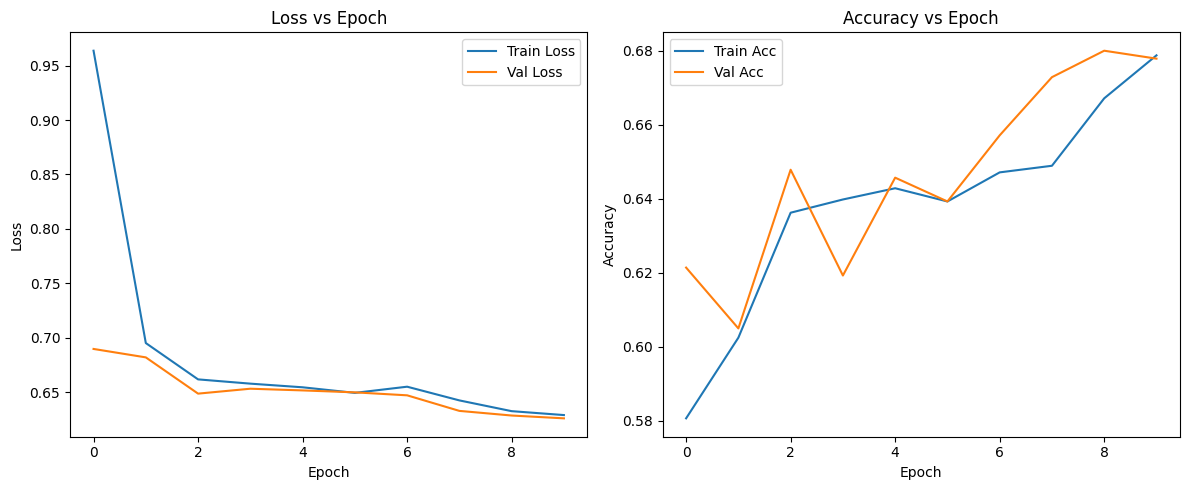

In [4]:
# ViT + MaxViT Hybrid (Performance VS No. of Epochs)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.amp import autocast, GradScaler
from transformers import ViTModel
import timm
import time

# === Dataset ===
class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

# === Model ===
class ViT_MaxViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = nn.Identity()
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + maxvit_dim, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_classes))

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

# === Train/Eval ===
def train_epoch(model, loader, criterion, opt, device, scaler):
    model.train(); loss_sum = correct = total = 0; start = time.time()
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        opt.zero_grad()
        with autocast(device_type='cuda'):
            out = model(imgs); loss = criterion(out, labels)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item(); total += labels.size(0)
    return loss_sum / total, correct / total, time.time() - start

def eval_epoch(model, loader, criterion, device):
    model.eval(); loss_sum = correct = total = 0
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast(device_type='cuda'):
                out = model(imgs); loss = criterion(out, labels)
                probs = torch.softmax(out, dim=1)[:, 1]
            loss_sum += loss.item() * imgs.size(0)
            preds = out.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return loss_sum / total, correct / total, precision_score(all_labels, all_preds), \
           recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), \
           roc_auc_score(all_labels, all_probs), confusion_matrix(all_labels, all_preds)

# === Unfreeze ===
def unfreeze_layers(model, vit=False, maxvit=False):
    if vit:
        for p in model.vit.parameters(): p.requires_grad = True
    if maxvit:
        for p in model.maxvit.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True

# === Main Loop ===
def run_training(npz_file, batch_size=16, num_epochs=15, device='cuda'):
    dataset = JetDataset(npz_file, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset)-train_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    model = ViT_MaxViT_Hybrid().to(device)
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    unfreeze_layers(model, vit=False, maxvit=False)
    best_val_loss, counter = float('inf'), 0
    train_losses, val_losses, train_accs, val_accs, times = [], [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        if epoch == 5:
            print("Unfreezing ViT..."); unfreeze_layers(model, vit=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.vit.parameters()), 'lr': 1e-5})
        elif epoch == 9:
            print("Unfreezing MaxViT..."); unfreeze_layers(model, vit=True, maxvit=True)
            optimizer.add_param_group({'params': filter(lambda p: p.requires_grad, model.maxvit.parameters()), 'lr': 1e-5})

        train_loss, train_acc, duration = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_acc, prec, rec, f1, roc, cm = eval_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss); val_losses.append(val_loss)
        train_accs.append(train_acc); val_accs.append(val_acc); times.append(duration)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Time: {duration:.2f}s")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        scheduler.step(epoch + val_loss)
        if val_loss < best_val_loss:
            best_val_loss, counter = val_loss, 0
            torch.save(model.state_dict(), 'best_vit_maxvit_hybrid.pth')
        else:
            counter += 1
            if counter >= 5:
                print("Early stopping triggered."); break

    model.eval()
    with torch.no_grad():
        t0 = time.time(); _ = model(torch.randn(1, 3, 224, 224).to(device)); t1 = time.time()
        print(f"\nInference Time (1 sample): {(t1 - t0) * 1000:.2f} ms")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()
    plt.subplot(1, 2, 2); plt.plot(train_accs, label='Train Acc'); plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    run_training('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz', batch_size=16, num_epochs=10)


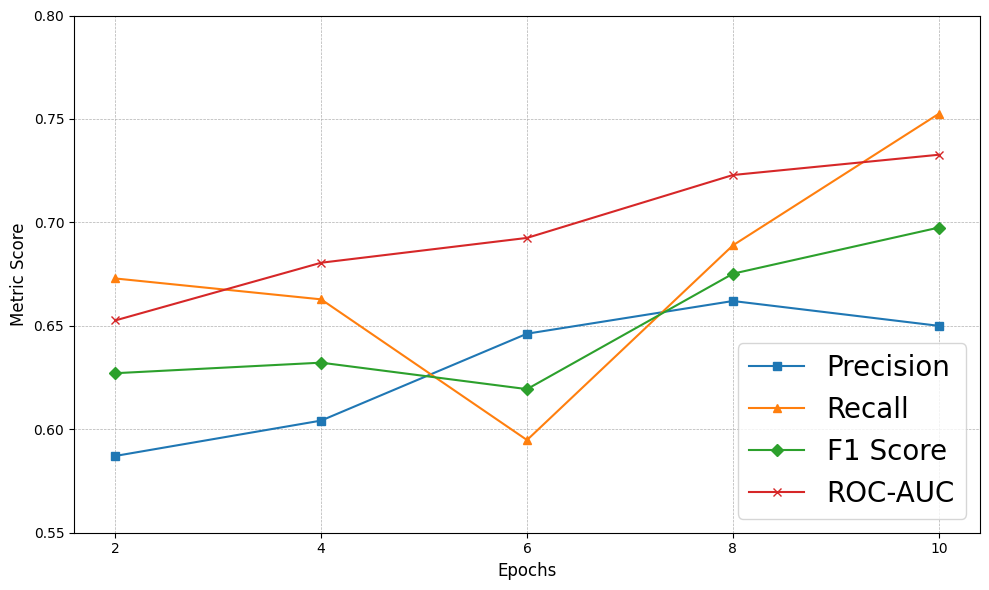

In [7]:
# ViT + MaxViT Hybrid (Performance VS No. of Epochs) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# === Define Data ===
epochs = [2, 4, 6, 8, 10]
val_acc = [0.6050, 0.6193, 0.6393, 0.6729, 0.6779]
precision = [0.5871, 0.6042, 0.6462, 0.6620, 0.6500]
recall = [0.6729, 0.6628, 0.5948, 0.6889, 0.7525]
f1 = [0.6271, 0.6322, 0.6194, 0.6752, 0.6975]
roc_auc = [0.6526, 0.6805, 0.6925, 0.7229, 0.7327]

# === Plot Metrics ===
plt.figure(figsize=(10, 6))
#plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.plot(epochs, precision, marker='s', label='Precision')
plt.plot(epochs, recall, marker='^', label='Recall')
plt.plot(epochs, f1, marker='D', label='F1 Score')
plt.plot(epochs, roc_auc, marker='x', label='ROC-AUC')

# === Styling for Q1 Journal Aesthetic ===
#plt.title('Model Performance Metrics vs Epochs', fontsize=14, weight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Metric Score', fontsize=12)
plt.xticks(epochs)
plt.ylim(0.55, 0.80)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=20)
plt.tight_layout()
plt.savefig("performance_vs_epochs.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [12]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS BatchSize)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs)
    )

def test_batch_sizes(npz_path, device='cuda'):
    batch_sizes = [8, 16, 32, 64, 128]
    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    results = []

    for bs in batch_sizes:
        torch.cuda.empty_cache()
        print(f"\n🧪 Testing Batch Size: {bs}")
        try:
            train_loader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)
            val_loader = DataLoader(val_set, batch_size=bs, shuffle=False, num_workers=2)

            model = ViT_MaxViT_Hybrid().to(device)
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-3)
            criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
            scaler = torch.cuda.amp.GradScaler()
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

            for p in model.classifier.parameters(): p.requires_grad = True

            for epoch in range(5):
                if epoch == 3:
                    for p in model.vit.parameters(): p.requires_grad = True
                    optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})

                model.train()
                for imgs, labels in tqdm(train_loader, desc=f"Batch {bs} - Epoch {epoch+1}", leave=False):
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.cuda.amp.autocast():
                        out = model(imgs)
                        loss = criterion(out, labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                scheduler.step(epoch + 1)

            prec, rec, f1, roc = evaluate_model(model, val_loader, device)
            results.append({
                'Batch Size': bs,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc
            })

        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print(f"❌ Skipped Batch Size {bs}: CUDA Out of Memory")
                torch.cuda.empty_cache()
            else:
                print(f"❌ Skipped Batch Size {bs}: {str(e)}")
                torch.cuda.empty_cache()
            continue

    df = pd.DataFrame(results)

    # === Plotting ===
    plt.figure(figsize=(10, 6))
    plt.plot(df['Batch Size'], df['Precision'], label='Precision', linewidth=2)
    plt.plot(df['Batch Size'], df['Recall'], label='Recall', linewidth=2)
    plt.plot(df['Batch Size'], df['F1 Score'], label='F1 Score', linewidth=2)
    plt.plot(df['Batch Size'], df['ROC-AUC'], label='ROC-AUC', linewidth=2)
    plt.xlabel('Batch Size', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs Batch Size', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("batchsize_vs_metrics.pdf", format="pdf")
    plt.show()

    return df


🧪 Testing Batch Size: 8


/tmp/ipykernel_35/3493007356.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Batch 8 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/3493007356.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🧪 Testing Batch Size: 16


/tmp/ipykernel_35/3493007356.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Batch 16 - Epoch 1:   0%|          | 0/350 [00:00<?, ?it/s]/tmp/ipykernel_35/3493007356.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🧪 Testing Batch Size: 32


/tmp/ipykernel_35/3493007356.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Batch 32 - Epoch 1:   0%|          | 0/175 [00:00<?, ?it/s]/tmp/ipykernel_35/3493007356.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🧪 Testing Batch Size: 64


/tmp/ipykernel_35/3493007356.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Batch 64 - Epoch 1:   0%|          | 0/88 [00:00<?, ?it/s]/tmp/ipykernel_35/3493007356.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🧪 Testing Batch Size: 128


/tmp/ipykernel_35/3493007356.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Batch 128 - Epoch 1:   0%|          | 0/44 [00:00<?, ?it/s]/tmp/ipykernel_35/3493007356.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


❌ Skipped Batch Size 128: CUDA Out of Memory


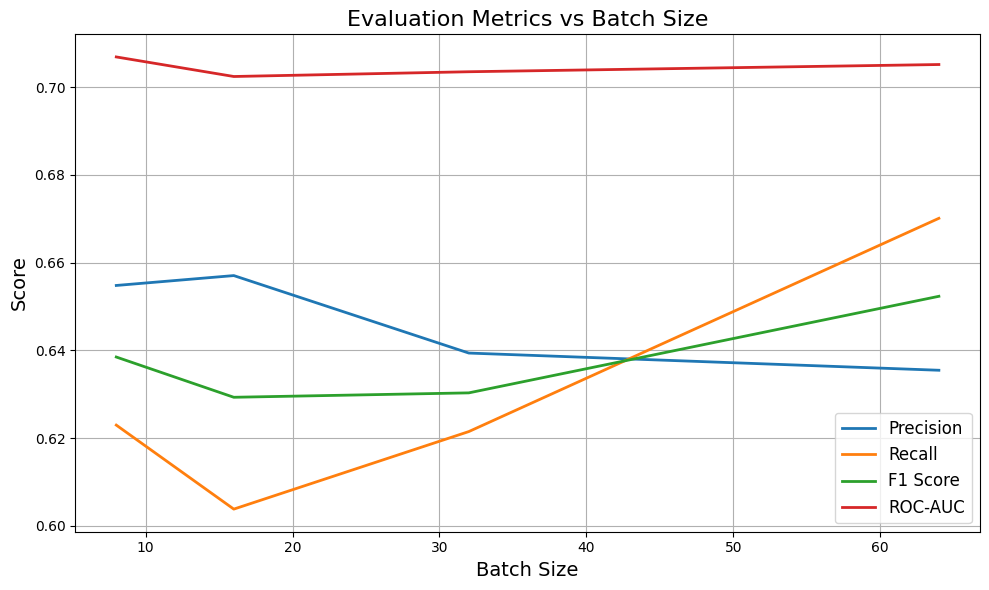

   Batch Size  Precision    Recall  F1 Score   ROC-AUC
0           8   0.654799  0.622975  0.638491  0.706879
1          16   0.657051  0.603829  0.629317  0.702422
2          32   0.639394  0.621502  0.630321  0.703506
3          64   0.635475  0.670103  0.652330  0.705151


In [13]:
df_batch = test_batch_sizes('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_batch)


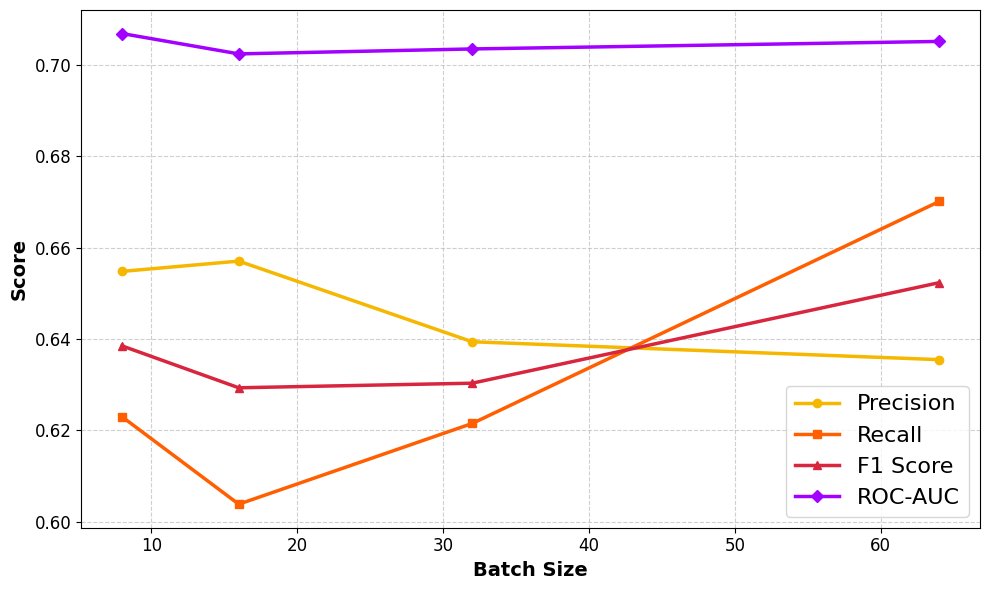

In [18]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS BatchSize) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# Sample data — replace with your actual results if needed
data = {
    "Batch Size": [8, 16, 32, 64],
    "Precision": [0.654799, 0.657051, 0.639394, 0.635475],
    "Recall": [0.622975, 0.603829, 0.621502, 0.670103],
    "F1 Score": [0.638491, 0.629317, 0.630321, 0.652330],
    "ROC-AUC": [0.706879, 0.702422, 0.703506, 0.705151]
}

df = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(10, 6))

plt.plot(df["Batch Size"], df["Precision"], marker='o', linewidth=2.5, label='Precision', color='#f5b700')
plt.plot(df["Batch Size"], df["Recall"], marker='s', linewidth=2.5, label='Recall', color='#ff5f00')
plt.plot(df["Batch Size"], df["F1 Score"], marker='^', linewidth=2.5, label='F1 Score', color='#d7263d')
plt.plot(df["Batch Size"], df["ROC-AUC"], marker='D', linewidth=2.5, label='ROC-AUC', color='#a200ff')

plt.xlabel("Batch Size", fontsize=14, weight='bold')
plt.ylabel("Score", fontsize=14, weight='bold')
#plt.title("Evaluation Metrics vs Batch Size", fontsize=16, weight='bold')
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save for journal submission
plt.savefig("batch_size_metrics_plot.pdf", format="pdf", dpi=300)
plt.show()



🚀 Testing Learning Rate: 1e-05


/tmp/ipykernel_35/1692470447.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
LR 1e-05 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1692470447.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🚀 Testing Learning Rate: 5e-05


/tmp/ipykernel_35/1692470447.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
LR 5e-05 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1692470447.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🚀 Testing Learning Rate: 0.0005


/tmp/ipykernel_35/1692470447.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
LR 5e-04 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1692470447.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



🚀 Testing Learning Rate: 0.001


/tmp/ipykernel_35/1692470447.py:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
LR 1e-03 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1692470447.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


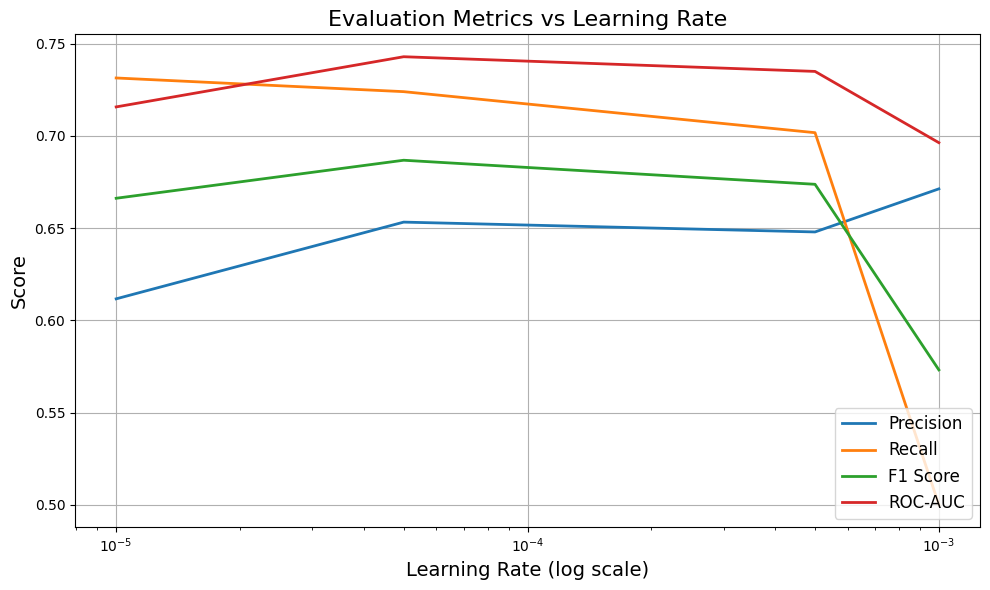

   Learning Rate  Precision    Recall  F1 Score   ROC-AUC
0        0.00001   0.611663  0.731454  0.666216  0.715761
1        0.00005   0.653280  0.724036  0.686840  0.742976
2        0.00050   0.647945  0.701780  0.673789  0.735014
3        0.00100   0.671315  0.500000  0.573129  0.696361


In [19]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS Learning Rate)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs)
    )

def test_learning_rates(npz_path, device='cuda'):
    learning_rates = [1e-5, 5e-5, 5e-4, 1e-3]
    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    results = []

    for lr in learning_rates:
        torch.cuda.empty_cache()
        print(f"\n🚀 Testing Learning Rate: {lr}")

        try:
            model = ViT_MaxViT_Hybrid().to(device)
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-3)
            criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
            scaler = torch.cuda.amp.GradScaler()
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

            for p in model.classifier.parameters(): p.requires_grad = True

            for epoch in range(10):
                if epoch == 5:
                    for p in model.vit.parameters(): p.requires_grad = True
                    optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})
                elif epoch == 9:
                    for p in model.maxvit.parameters(): p.requires_grad = True
                    optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.maxvit.parameters()), "lr": 1e-5})

                model.train()
                for imgs, labels in tqdm(train_loader, desc=f"LR {lr:.0e} - Epoch {epoch+1}", leave=False):
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.cuda.amp.autocast():
                        out = model(imgs)
                        loss = criterion(out, labels)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                scheduler.step(epoch + 1)

            prec, rec, f1, roc = evaluate_model(model, val_loader, device)
            results.append({
                'Learning Rate': lr,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc
            })

        except RuntimeError as e:
            print(f"❌ Skipped Learning Rate {lr}: {str(e).splitlines()[0]}")
            torch.cuda.empty_cache()
            continue

    if not results:
        print("❌ All configurations failed due to memory constraints.")
        return pd.DataFrame()

    df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    for metric in ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        plt.plot(df['Learning Rate'], df[metric], label=metric, linewidth=2)
    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs Learning Rate', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("lr_vs_metrics.pdf", format="pdf")
    plt.show()

    return df

df_lr = test_learning_rates('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_lr)


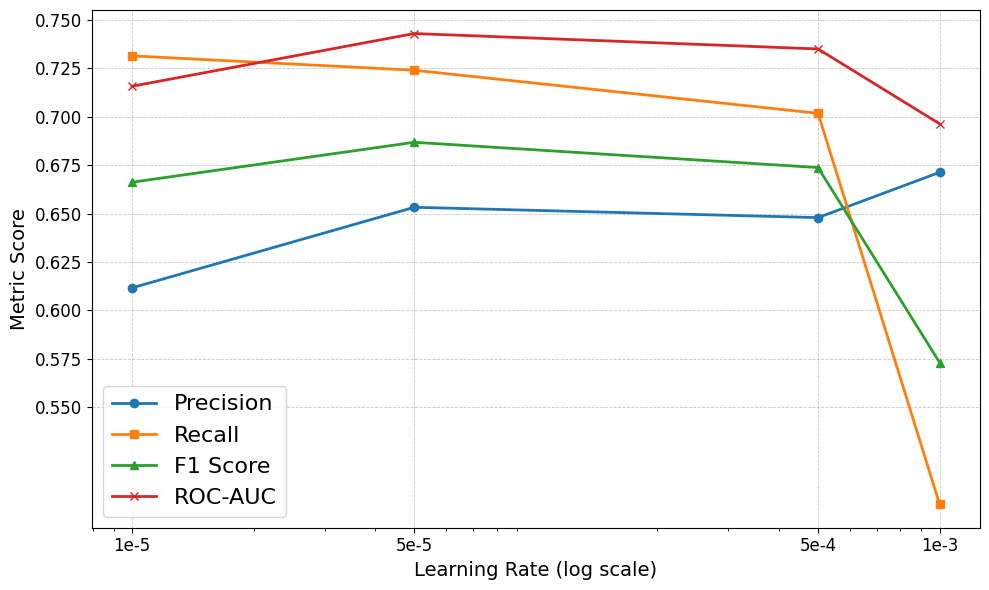

In [25]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS Learning Rate) - Chart

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Define Data ===
data = {
    'Learning Rate': [1e-5, 5e-5, 5e-4, 1e-3],
    'Precision': [0.611663, 0.653280, 0.647945, 0.671315],
    'Recall': [0.731454, 0.724036, 0.701780, 0.500000],
    'F1 Score': [0.666216, 0.686840, 0.673789, 0.573129],
    'ROC-AUC': [0.715761, 0.742976, 0.735014, 0.696361]
}

df = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['Learning Rate'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['Learning Rate'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['Learning Rate'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['Learning Rate'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# === Styling ===
plt.xscale('log')
plt.xticks([1e-5, 5e-5, 5e-4, 1e-3], ['1e-5', '5e-5', '5e-4', '1e-3'], fontsize=12)
plt.yticks(np.arange(0.55, 0.77, 0.025), fontsize=12)
plt.xlabel('Learning Rate (log scale)', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
#plt.title('Model Performance vs Learning Rate', fontsize=16, weight='bold')
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower left', fontsize=16)
plt.tight_layout()

# === Save as High-Quality PDF ===
plt.savefig("learning_rate_vs_performance_improved.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS Weight Decay)

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs),
        confusion_matrix(all_labels, all_preds)
    )

def test_weight_decay(npz_path, device='cuda'):
    decay_values = [0, 0.01, 0.05, 0.1]

    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    results = []

    for decay in decay_values:
        torch.cuda.empty_cache()
        print(f"\n🚀 Testing Weight Decay: {decay}")

        model = ViT_MaxViT_Hybrid().to(device)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=decay)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        scaler = torch.cuda.amp.GradScaler()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        for p in model.classifier.parameters(): p.requires_grad = True

        for epoch in range(10):
            print(f"Epoch {epoch+1}/10")
            if epoch == 5:
                for p in model.vit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})
            elif epoch == 9:
                for p in model.maxvit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.maxvit.parameters()), "lr": 1e-5})

            model.train()
            for imgs, labels in tqdm(train_loader, desc=f"Decay {decay} - Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    out = model(imgs)
                    loss = criterion(out, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            scheduler.step(epoch + 1)

            prec, rec, f1, roc, cm = evaluate_model(model, val_loader, device)
            print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        prec, rec, f1, roc, _ = evaluate_model(model, val_loader, device)
        results.append({
            'Weight Decay': decay,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC-AUC': roc
        })

    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    for metric in ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        plt.plot(df['Weight Decay'], df[metric], label=metric, linewidth=2, marker='o')
    plt.xlabel('Weight Decay', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs Weight Decay', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("weight_decay_vs_metrics.pdf", format="pdf")
    plt.show()

    return df

df_decay = test_weight_decay('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_decay)



🚀 Testing Weight Decay: 0


/tmp/ipykernel_35/4130922610.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10


Decay 0 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6169 | Recall: 0.6880 | F1: 0.6505 | ROC-AUC: 0.6852
CM:
[[398 300]
 [219 483]]
Epoch 2/10


Decay 0 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6443 | Recall: 0.5883 | F1: 0.6150 | ROC-AUC: 0.6818
CM:
[[470 228]
 [289 413]]
Epoch 3/10


Decay 0 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6218 | Recall: 0.7379 | F1: 0.6749 | ROC-AUC: 0.7028
CM:
[[383 315]
 [184 518]]
Epoch 4/10


Decay 0 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6269 | Recall: 0.6895 | F1: 0.6567 | ROC-AUC: 0.6938
CM:
[[410 288]
 [218 484]]
Epoch 5/10


Decay 0 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6556 | Recall: 0.6453 | F1: 0.6504 | ROC-AUC: 0.7113
CM:
[[460 238]
 [249 453]]
Epoch 6/10


Decay 0 - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6543 | Recall: 0.7037 | F1: 0.6781 | ROC-AUC: 0.7171
CM:
[[437 261]
 [208 494]]
Epoch 7/10


Decay 0 - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6682 | Recall: 0.6368 | F1: 0.6521 | ROC-AUC: 0.7150
CM:
[[476 222]
 [255 447]]
Epoch 8/10


Decay 0 - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6566 | Recall: 0.6809 | F1: 0.6685 | ROC-AUC: 0.7194
CM:
[[448 250]
 [224 478]]
Epoch 9/10


Decay 0 - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6544 | Recall: 0.7607 | F1: 0.7036 | ROC-AUC: 0.7355
CM:
[[416 282]
 [168 534]]
Epoch 10/10


Decay 0 - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7237 | Recall: 0.5783 | F1: 0.6429 | ROC-AUC: 0.7485
CM:
[[543 155]
 [296 406]]



🚀 Testing Weight Decay: 0.01


/tmp/ipykernel_35/4130922610.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10


Decay 0.01 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6505 | Recall: 0.4402 | F1: 0.5251 | ROC-AUC: 0.6681
CM:
[[532 166]
 [393 309]]
Epoch 2/10


Decay 0.01 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6381 | Recall: 0.6681 | F1: 0.6527 | ROC-AUC: 0.7004
CM:
[[432 266]
 [233 469]]
Epoch 3/10


Decay 0.01 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6329 | Recall: 0.7464 | F1: 0.6850 | ROC-AUC: 0.7112
CM:
[[394 304]
 [178 524]]
Epoch 4/10


Decay 0.01 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6890 | Recall: 0.5271 | F1: 0.5973 | ROC-AUC: 0.6945
CM:
[[531 167]
 [332 370]]
Epoch 5/10


Decay 0.01 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6541 | Recall: 0.6410 | F1: 0.6475 | ROC-AUC: 0.7027
CM:
[[460 238]
 [252 450]]
Epoch 6/10


Decay 0.01 - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6631 | Recall: 0.6225 | F1: 0.6422 | ROC-AUC: 0.7110
CM:
[[476 222]
 [265 437]]
Epoch 7/10


Decay 0.01 - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.7007 | Recall: 0.5670 | F1: 0.6268 | ROC-AUC: 0.7200
CM:
[[528 170]
 [304 398]]
Epoch 8/10


Decay 0.01 - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6619 | Recall: 0.7279 | F1: 0.6934 | ROC-AUC: 0.7360
CM:
[[437 261]
 [191 511]]
Epoch 9/10


Decay 0.01 - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6883 | Recall: 0.6795 | F1: 0.6839 | ROC-AUC: 0.7357
CM:
[[482 216]
 [225 477]]
Epoch 10/10


Decay 0.01 - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6864 | Recall: 0.6952 | F1: 0.6907 | ROC-AUC: 0.7430
CM:
[[475 223]
 [214 488]]



🚀 Testing Weight Decay: 0.05


/tmp/ipykernel_35/4130922610.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10


Decay 0.05 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6803 | Recall: 0.4972 | F1: 0.5745 | ROC-AUC: 0.6800
CM:
[[534 164]
 [353 349]]
Epoch 2/10


Decay 0.05 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/4130922610.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Decay 0.05 - Epoch 2:  98%|█████████▊| 683/700 [01:17<00:01,  8.85it/s]

In [ ]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS Weight Decay) 

import torch
import numpy as np
import time
import psutil
import GPUtil
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.transforms import InterpolationMode
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import ViTModel
import timm
from tqdm import tqdm
from torch import optim

class JetDataset(Dataset):
    def __init__(self, npz_file, train=True):
        data = np.load(npz_file)
        self.X = data['X']
        self.y = data['y']
        self.transform = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop(224, scale=(0.7, 1.0), interpolation=InterpolationMode.BILINEAR),
            T.RandomHorizontalFlip(),
            T.ColorJitter(0.3, 0.3, 0.2, 0.1),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]) if train else T.Compose([
            T.ToPILImage(),
            T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = (self.X[idx] * 255).astype(np.uint8) if self.X[idx].dtype != np.uint8 else self.X[idx]
        return self.transform(img), torch.tensor(self.y[idx], dtype=torch.long)

class ViT_MaxViT_Hybrid(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.maxvit = timm.create_model('maxvit_base_tf_224', pretrained=True)
        for p in self.vit.parameters(): p.requires_grad = False
        for p in self.maxvit.parameters(): p.requires_grad = False
        vit_dim = self.vit.config.hidden_size
        maxvit_dim = self.maxvit.head.in_features
        self.maxvit.head = torch.nn.Identity()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(vit_dim + maxvit_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        vit_cls = self.vit(pixel_values=x).last_hidden_state[:, 0]
        max_feat = torch.mean(self.maxvit.forward_features(x), dim=[2, 3])
        return self.classifier(torch.cat((vit_cls, max_feat), dim=1))

def evaluate_model(model, val_loader, device):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            probs = torch.softmax(out, dim=1)[:, 1]
            preds = out.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return (
        precision_score(all_labels, all_preds),
        recall_score(all_labels, all_preds),
        f1_score(all_labels, all_preds),
        roc_auc_score(all_labels, all_probs),
        confusion_matrix(all_labels, all_preds)
    )

def test_weight_decay(npz_path, device='cuda'):
    decay_values = [0.05, 0.1]

    dataset = JetDataset(npz_path, train=True)
    train_size = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_size, len(dataset) - train_size])
    train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

    results = []

    for decay in decay_values:
        torch.cuda.empty_cache()
        print(f"\n🚀 Testing Weight Decay: {decay}")

        model = ViT_MaxViT_Hybrid().to(device)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=decay)
        criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
        scaler = torch.cuda.amp.GradScaler()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

        for p in model.classifier.parameters(): p.requires_grad = True

        for epoch in range(10):
            print(f"Epoch {epoch+1}/10")
            if epoch == 5:
                for p in model.vit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.vit.parameters()), "lr": 1e-5})
            elif epoch == 9:
                for p in model.maxvit.parameters(): p.requires_grad = True
                optimizer.add_param_group({"params": filter(lambda p: p.requires_grad, model.maxvit.parameters()), "lr": 1e-5})

            model.train()
            for imgs, labels in tqdm(train_loader, desc=f"Decay {decay} - Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.cuda.amp.autocast():
                    out = model(imgs)
                    loss = criterion(out, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            scheduler.step(epoch + 1)

            prec, rec, f1, roc, cm = evaluate_model(model, val_loader, device)
            print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\nCM:\n{cm}")

        prec, rec, f1, roc, _ = evaluate_model(model, val_loader, device)
        results.append({
            'Weight Decay': decay,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC-AUC': roc
        })

    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 6))
    for metric in ['Precision', 'Recall', 'F1 Score', 'ROC-AUC']:
        plt.plot(df['Weight Decay'], df[metric], label=metric, linewidth=2, marker='o')
    plt.xlabel('Weight Decay', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Evaluation Metrics vs Weight Decay', fontsize=16)
    plt.legend(fontsize=12, title_fontsize=12, loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("weight_decay_vs_metrics.pdf", format="pdf")
    plt.show()

    return df

df_decay = test_weight_decay('/kaggle/input/qg-data/preprocessed_jet_data - 7000.npz')
print(df_decay)


2025-05-23 11:44:34.856618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748000675.057319      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748000675.115971      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



🚀 Testing Weight Decay: 0.05


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

/tmp/ipykernel_35/1515397039.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10


Decay 0.05 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5991 | Recall: 0.5636 | F1: 0.5808 | ROC-AUC: 0.6542
CM:
[[469 255]
 [295 381]]
Epoch 2/10


Decay 0.05 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6198 | Recall: 0.5281 | F1: 0.5703 | ROC-AUC: 0.6640
CM:
[[505 219]
 [319 357]]
Epoch 3/10


Decay 0.05 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.5916 | Recall: 0.6879 | F1: 0.6361 | ROC-AUC: 0.6705
CM:
[[403 321]
 [211 465]]
Epoch 4/10


Decay 0.05 - Epoch 4:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6450 | Recall: 0.6021 | F1: 0.6228 | ROC-AUC: 0.7022
CM:
[[500 224]
 [269 407]]
Epoch 5/10


Decay 0.05 - Epoch 5:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6179 | Recall: 0.6124 | F1: 0.6152 | ROC-AUC: 0.6839
CM:
[[468 256]
 [262 414]]
Epoch 6/10


Decay 0.05 - Epoch 6:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6092 | Recall: 0.6686 | F1: 0.6375 | ROC-AUC: 0.6856
CM:
[[434 290]
 [224 452]]
Epoch 7/10


Decay 0.05 - Epoch 7:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6376 | Recall: 0.6169 | F1: 0.6271 | ROC-AUC: 0.6811
CM:
[[487 237]
 [259 417]]
Epoch 8/10


Decay 0.05 - Epoch 8:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6564 | Recall: 0.6642 | F1: 0.6603 | ROC-AUC: 0.7212
CM:
[[489 235]
 [227 449]]
Epoch 9/10


Decay 0.05 - Epoch 9:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6742 | Recall: 0.5725 | F1: 0.6192 | ROC-AUC: 0.7248
CM:
[[537 187]
 [289 387]]
Epoch 10/10


Decay 0.05 - Epoch 10:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6426 | Recall: 0.6967 | F1: 0.6686 | ROC-AUC: 0.7247
CM:
[[462 262]
 [205 471]]



🚀 Testing Weight Decay: 0.1


/tmp/ipykernel_35/1515397039.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10


Decay 0.1 - Epoch 1:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6155 | Recall: 0.6464 | F1: 0.6306 | ROC-AUC: 0.6921
CM:
[[451 273]
 [239 437]]
Epoch 2/10


Decay 0.1 - Epoch 2:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Precision: 0.6022 | Recall: 0.7456 | F1: 0.6662 | ROC-AUC: 0.6935
CM:
[[391 333]
 [172 504]]
Epoch 3/10


Decay 0.1 - Epoch 3:   0%|          | 0/700 [00:00<?, ?it/s]/tmp/ipykernel_35/1515397039.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating:  59%|█████▉    | 103/175 [00:33<00:23,  3.12it/s]         

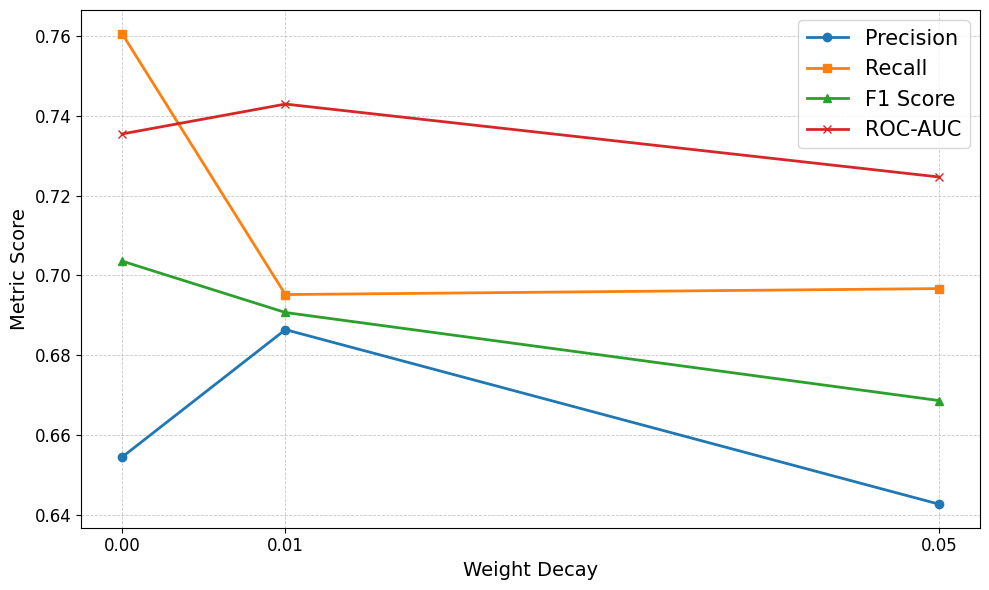

In [33]:
#Varying BatchSize# ViT + MaxViT Hybrid (Performance VS Weight Decay) - Chart

import matplotlib.pyplot as plt
import pandas as pd

# === Define Data ===
data = {
    'Weight Decay': [0.00, 0.01, 0.05],
    'Precision': [0.6544, 0.6864, 0.6426],
    'Recall': [0.7607, 0.6952, 0.6967],
    'F1 Score': [0.7036, 0.6907, 0.6686],
    'ROC-AUC': [0.7355, 0.7430, 0.7247]
}

df = pd.DataFrame(data)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['Weight Decay'], df['Precision'], marker='o', label='Precision', linewidth=2)
plt.plot(df['Weight Decay'], df['Recall'], marker='s', label='Recall', linewidth=2)
plt.plot(df['Weight Decay'], df['F1 Score'], marker='^', label='F1 Score', linewidth=2)
plt.plot(df['Weight Decay'], df['ROC-AUC'], marker='x', label='ROC-AUC', linewidth=2)

# === Styling for Journal ===
#plt.title('Model Performance vs Weight Decay', fontsize=16, weight='bold')
plt.xlabel('Weight Decay', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.xticks(df['Weight Decay'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.savefig("weight_decay_vs_performance.pdf", format='pdf', bbox_inches='tight')
plt.show()
